**Connect to google drive and load dataset for fine-tunnining model**

In [1]:
# connection to google drive
odrive='https://drive.google.com/drive/my-drive'
from google.colab import drive
drive.mount('odrive', force_remount=True)

import json,random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

!pip install transformers==4.41.0

import transformers,torch, numpy as np
torch.cuda.empty_cache()
from torch import nn

from transformers import BertTokenizer, BertModel, AdamW
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained("bert-base-uncased")

import numpy as np
from scipy import spatial



#Load data for building model
path2data='odrive/My Drive/trainp4p.txt'

import json,random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

with open(path2data) as f1:
  data1=json.load(f1)
  data2=[x for x in data1 if x[1]!=1]
  data1.extend(data2)
  f1.close()

random.shuffle(data1)
dataset=[x[0] for x in data1]
gstandard=[x[1] for x in data1]

Mounted at odrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Function to fine-tune Bert model to the specific downstream task:**

In [5]:
class BERTBaseUncased(nn.Module):
    def __init__(self,bert):
        super(BERTBaseUncased, self).__init__()
        self.bert = bert
        #self.bert = bert#transformers.BertModel.from_pretrained(config.BERT_PATH)
        self.bert_drop = nn.Dropout(0.3)
        self.linear=nn.Linear(768,2)
        self.softmax = nn.Softmax(dim=1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, ids, mask):
        #o1,o2 = self.bert(ids, token_type_ids = token_type_ids, attention_mask=mask)
        bert_arg = self.bert(ids, attention_mask=mask)
        o2=bert_arg[1]
        o2=self.bert_drop(o2)
        o2=self.linear(o2)
        return self.softmax(o2)


model = BERTBaseUncased(bert)

#push the model to GPU
model = model.to('cuda')

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

#criterion
cross=nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**Tokenize and load data using the Bert tokenizer and data loader**

In [6]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
MAX_LEN = 512
sent1=[x[0] for x in dataset]
sent2=[x[1] for x in dataset]

def tok1(_data,gstand):
  tokens_train = TOKENIZER.batch_encode_plus(_data, max_length =MAX_LEN, pad_to_max_length=True, truncation=True, return_token_type_ids=True)
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  token_type_ids=torch.tensor(tokens_train['token_type_ids'])
  train_y=torch.tensor(gstand, dtype=torch.long)
  train_data = TensorDataset(train_seq, train_mask, token_type_ids, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return train_dataloader

train_sent1=tok1(sent1[:int(len(sent1)*0.7)],gstandard[:int(len(gstandard)*0.7)])
train_sent2=tok1(sent2[:int(len(sent2)*0.7)],gstandard[:int(len(gstandard)*0.7)])
valid_sent1=tok1(sent1[:int(len(sent1[::-1])*0.3)],gstandard[:int(len(gstandard[::-1])*0.3)])
valid_sent2=tok1(sent2[:int(len(sent1[::-1])*0.3)],gstandard[:int(len(gstandard[::-1])*0.3)])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**BERT layers chosen for fine-tunning (lower layers that captures generic features)**

In [7]:
Bert_layers=0
while Bert_layers<6:
  for param in list(bert.parameters()):#[::-1]:
    Bert_layers=Bert_layers + 1
    param.requires_grad = False

**Fine-tunning BERT model on the downstream task (using the training data)**

In [8]:
from torch.autograd import Variable
def compute_accuracy(_true, _prob):
    _prob = _prob > 0.6
    return (_true == _prob).sum().item() / _true.size(0)

#train_seq, train_mask, token_type_ids, train_y
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,data in enumerate(zip(train_sent1,train_sent2),0):
    sent_id, mask, toks_id, labels = data[0]
    #inputs=sent_id, toks_id, mask
    sent_id=sent_id.to('cuda')
    toks_id=toks_id.to('cuda')
    mask=mask.to('cuda')
    labels=Variable(labels).to('cuda')
    #labels = labels.unsqueeze(1)

    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model(sent_id,mask)
    loss = cross(outputs, labels)
    loss.backward()
    optimizer.step()
    #accura=get_accuracy(labels,outputs)
    accuracy = (outputs.argmax(dim=1)== labels).sum().float() / len(labels)
    #corrects = (winners == labels)


    total_accuracy += accuracy#(outputs == labels).float().sum()


    total_loss = total_loss + loss.item()


    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


    total_preds.append(outputs)

  # compute training loss per epoch
  avg_loss = total_loss / len(train_sent1)
  avg_acc= total_accuracy / len(train_sent1)

  #total_preds  = np.concatenate(total_preds, axis=0)

  #returns loss and predictions
  return avg_loss, avg_acc, total_preds

***Evaluating BERT (fine-tuned) using the evaluation set (on the downstream task)  ***

In [9]:
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  loss_accumu=[]
  # empty list to save the model predictions
  total_preds = []
  total_accu = []
  ttloss=[]
  # iterate over batches
  with torch.no_grad():
      for step,batch in enumerate(zip(valid_sent1,valid_sent2),0):
        sent_id, mask, toks_id, labels = batch[0]
        #inputs=sent_id, toks_id, mask
        sent_id=sent_id.to('cuda')
        toks_id=toks_id.to('cuda')
        mask=mask.to('cuda')
        labels=Variable(labels).to('cuda')


        outputs1 = model(sent_id,mask)

        #labels=torch.tensor(labels.reshape(outputs1.shape)).to(torch.float32)

        loss=cross(outputs1, labels)

        total_loss = total_loss + loss.item()
        #total_accuracy += (outputs1 == labels).float().sum()

        #accura=get_accuracy(labels,outputs1)
        accuracy = (outputs1.argmax(dim=1)== labels).sum().float() / len(labels)
        total_accuracy += accuracy

        ttloss.append(loss.item())
        # clip gradients to 1.0. to avoid the exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)



        # Send model predictions to CPU
        outputs1=outputs1.detach().cpu().numpy()

        total_preds.append(outputs1)

  avg_loss=np.average(ttloss)

  avg_cc=total_accuracy/float(len(valid_sent1))

  _preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, avg_cc, _preds

**Computing training and evaluation performances**



 Epoch 1 / 5

Evaluating...

Training Loss: 0.614, Validation Loss: 0.492

Training Accuracy: 0.630, Validation Accuracy: 0.854

 Epoch 2 / 5

Evaluating...

Training Loss: 0.579, Validation Loss: 0.470

Training Accuracy: 0.672, Validation Accuracy: 0.839

 Epoch 3 / 5

Evaluating...

Training Loss: 0.601, Validation Loss: 0.476

Training Accuracy: 0.671, Validation Accuracy: 0.854

 Epoch 4 / 5

Evaluating...

Training Loss: 0.578, Validation Loss: 0.470

Training Accuracy: 0.703, Validation Accuracy: 0.870

 Epoch 5 / 5

Evaluating...

Training Loss: 0.584, Validation Loss: 0.464

Training Accuracy: 0.692, Validation Accuracy: 0.925


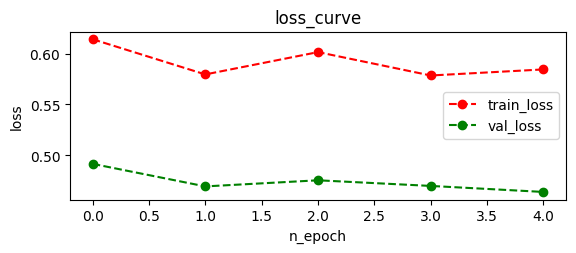

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')
#cross = nn.BCELoss()



# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


train_accuracies=[]
valid_accuracies=[]
epochs=5
#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accu,  _ = train()

    #evaluate model
   # model_name='model_bert.pt'
    valid_loss, valid_accu, _ = evaluate()

    #path='odrive/My Drive/model_bert5.pt'
    #save the best model
    #if valid_loss < best_valid_loss:
        #best_valid_loss = valid_loss
        #torch.save(model.state_dict(), path)

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accu)
    valid_accuracies.append(valid_accu)


    print(f'\nTraining Loss: {train_loss:.3f}' ',', f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accu:.3f}' ',', f'Validation Accuracy: {valid_accu:.3f}')

from matplotlib import pyplot
def loss_gradient(plotid, graph_title,tra,val,loss_accuracy,train_data, val_data):
  pyplot.subplot(plotid)
  pyplot.title(graph_title)
  pyplot.plot(train_data, label=tra, marker='o', linestyle='--', color='r')
  pyplot.plot(val_data, label=val, marker='o', linestyle='--', color='g')
  pyplot.xlabel('n_epoch')
  pyplot.ylabel(loss_accuracy)
  pyplot.legend()
  pyplot.show()

loss_gradient(212, 'loss_curve', 'train_loss', 'val_loss', 'loss', train_losses, valid_losses)
#loss_gradient(212, 'accuracy_curve', 'train_accuracy', 'val_accuracy', 'accuracy', train_accuracies, valid_accuracies)

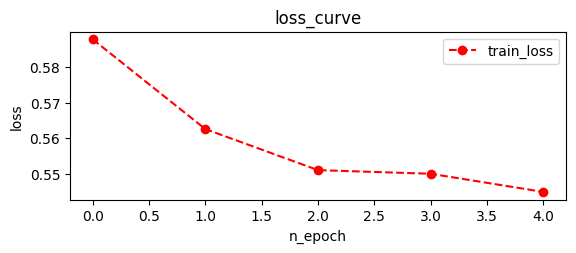

In [ ]:
loss_gradient(212, 'loss_curve', 'train_loss', '', 'loss', train_losses, valid_losses)

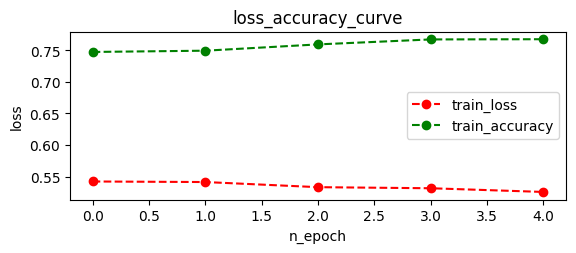

In [ ]:
def loss_gradient1(plotid, graph_title,tra,val,loss_accuracy,train_data, val_data):
  pyplot.subplot(plotid)
  pyplot.title(graph_title)
  pyplot.plot(train_data, label=tra, marker='o', linestyle='--', color='r')
  pyplot.plot(val_data, label=val, marker='o', linestyle='--', color='g')
  pyplot.xlabel('n_epoch')
  pyplot.ylabel(loss_accuracy)
  pyplot.legend()
  pyplot.show()
trainy=[x.cpu().numpy() for x in train_accuracies]
loss_gradient1(211, 'loss_accuracy_curve', 'train_loss', 'train_accuracy', 'loss',train_losses , trainy)
#[x.cpu().numpy() for x in train_accuracies]

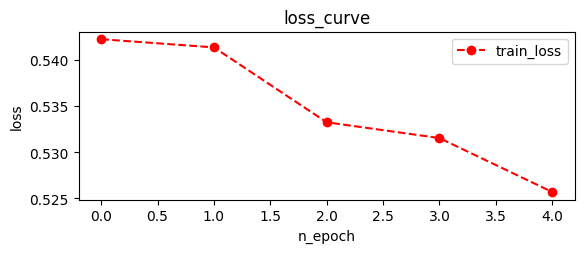

In [ ]:
loss_gradient(212, 'loss_curve', 'train_loss', '', 'loss', train_losses, valid_losses)